In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.arima_model import ARMA

In [2]:
file = "D:\\matst\\sem6\\ZRP\\Data_ZRP.csv" 
df = pd.read_csv(file, parse_dates = ['Data'], index_col = 'Data')
df['Coal_pct'] = df.Coal.pct_change().mul(100) 
df.head()

,Coal,Natural_Gas,Coal_pct
Data,,,
2009-12-31,83.60,5.666,NaN
2010-01-04,88.65,5.720,6.040670
2010-01-05,93.00,5.783,4.906937
2010-01-06,93.30,5.638,0.322581
2010-01-07,96.65,5.941,3.590568


In [3]:
historic = df.Coal_pct.loc['2015':'2016'] 
actual = df.Coal_pct.loc['01-04-2017':]

In [4]:
data = df.Coal_pct.loc['2015':]

In [14]:
#parametric
def Par_Norm(data, level):
    """
    input
    data: vector of portfolio returns
    level: 1-alpha, where alpha is a statistical significance
    output:
    Value at Risk determined parametric method with normal distribution
    """
    mean = data.mean()
    std = data.std()
    return(stats.norm.ppf(level, loc = mean, scale = std))
#historical
def Hist(data, level):
    """
    input
    data: vector of portfolio returns
    level: 1-alpha, where alpha is a statistical significance
    output:
    Value at Risk determined historical method 
    """
    return(np.percentile(data.values, level*100))
#historical weighted
def His_weight(data, level):
    """
    input
    data: vector of portfolio returns
    level: 1-alpha, where alpha is a statistical significance
    output:
    Value at Risk determined historical weighted method 
    """
    data = pd.DataFrame(data)
    N = len(data) - 1
    lda = level
    S = lda*(1-lda**N)/(1-lda)
    w1 = 1/(1+S)
    data['weighted'] = w1*np.cumprod(np.concatenate([np.array([1]), lda*np.ones(N)]))[::-1]
    temp = data.sort_values('Coal_pct')
    temp['pr'] = temp['weighted'].cumsum()
    return temp[temp['pr'] >= level].iloc[0]['Coal_pct']
#Monte Carlo
def mc(data, level):
    """
    input
    data: vector of portfolio returns
    level: 1-alpha, where alpha is a statistical significance
    output:
    Value at Risk determined Monte Carlo method with MA(1)
    """
    model = ARMA(data, order = (0,1)).fit()
    mu, theta = model.params
    random_sample = np.random.normal(loc = np.mean(model.resid), scale = np.std(model.resid), size = 10000)
    predictions = mu + random_sample + theta*model.resid[-1]
    return np.percentile(predictions, level)

In [15]:
def Var_vector(data, Varfunction, alpha):
    """ 
    input
    data: vector of portfolio returns
    Varfunction: function determining value at risk 
    alpha: statistical significance
    output
    var_vector: forecast of VaR for each day
    data[2*year:] : actual value of portfolio returns
    """
    year = 365 
    data_len = len(data) 
    var_len = data_len-2*year #range - 2 years
    var_vector = np.empty(var_len, float)
    for i in range(var_len): 
        var_vector[i] = Varfunction( data[i : (2*year+i)], (1-alpha) )
    return(var_vector, data[2*year:])
        
    

In [16]:
def Christoffersen_backtesting(actual, forecast, alpha, model=None):
    """ 
    input
    actual: portfolio returns
    forecast: Value at risk -dictionary or scalar
    alpha: statistical significance
    output:
    dataframe: columns: model, Statistic, alpha,  p-value, test outcome 
    """
    results = []
    if type(forecast) == dict:
        for key in forecast:
            I = (actual > forecast[key])*1 
            con = I[1:]-I[:-1] 
            n01, n10 = (con == 1).sum(), (con == -1).sum() 
            n11, n00 = (I[1:][con == 0] == 1).sum(), (I[1:][con == 0] == 0).sum()
            p0 = n01/(n00 + n01)         
            p1 = n11/(n10 + n11)
            p = (n01 + n11)/(n00 + n01 + n10 + n11)
            # indepedence
            LR = -2*np.log((1 - p)**(n00+n10)*p**(n01 + n11)/((1-p0)**(n00)*p0**n01*(1-p1)**n10*p1**n11))
            #chi = stats.chi2.isf(q=alpha, df=1)
            chi = 1 - stats.chi2.cdf(LR,  df=1)
            if chi<LR:
                ans = "reject"
            else:
                ans = "accept"
            results.append({"Model": key,"alpha": alpha, "Statistic": LR, "p-value": chi, "result": ans})
           
    else:
        I = (actual < forecast)*1 
        con = I[1:]-I[:-1] 
        n01, n10 = (con == 1).sum(), (con == -1).sum() 
        n11, n00 = (I[1:][con == 0] == 1).sum(), (I[1:][con == 0] == 0).sum()
        p0 = n01/(n00 + n01)         
        p1 = n11/(n10 + n11)
        p = (n01 + n11)/(n00 + n01 + n10 + n11)
        LR = -2*np.log((1 - p)**(n00+n10)*p**(n01 + n11)/((1-p0)**(n00)*p0**n01*(1-p1)**n10*p1**n11))
        chi = 1 - stats.chi2.cdf(LR,  df=1)
        #chi = stats.chi2.isf(q=alpha, df=1)
        if chi<LR:
            ans = "reject"
        else:
            ans = "accept"
        if model is not None:
            name = model
        else:
            name = " - "
        results = {"Model": [name],"alpha": [alpha],"Statistic": [LR], "p-value": [chi], "result": [ans]}
    results = pd.DataFrame(data=results)
    return (results)

In [21]:
Mvar5, Mdays = Var_vector(data, mc ,0.05)

C:\Users\Karolina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Karolina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Karolina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Karolina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency informati

In [24]:
Pvar5, days = Var_vector(data, Par_Norm ,0.05)
Hvar5, Hdays =  Var_vector(data, Hist ,0.05)
HWvar5, HWdays = Var_vector(data, His_weight ,0.05)

forecast5 = {"parametric": Pvar5, "historical": Hvar5,"historical weighted": HWvar5,"Monte Carlo":Mvar5}
Christoffersen_backtesting(days.values, forecast5, 0.05, 'parametric')

,Model,Statistic,alpha,p-value,result
0,historical weighted,0.158700,0.05,0.690356,accept
1,historical,0.149259,0.05,0.699244,accept
2,Monte Carlo,0.149259,0.05,0.699244,accept
3,parametric,0.149259,0.05,0.699244,accept


In [25]:
Mvar9, Mdays = Var_vector(data, mc ,0.01)

C:\Users\Karolina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Karolina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Karolina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Karolina\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency informati

In [27]:
Pvar9, Pdays = Var_vector(data, Par_Norm ,0.01)
Hvar9, Hdays =  Var_vector(data, Hist ,0.01)
HWvar9, HWdays = Var_vector(data, His_weight ,0.01)
forecast9= {"parametric": Pvar9, "historical": Hvar9,"historical weighted": HWvar9, "Monte Carlo":Mvar9}
Christoffersen_backtesting(days.values, forecast9, 0.01, 'parametric')

,Model,Statistic,alpha,p-value,result
0,historical weighted,0.149259,0.01,0.699244,accept
1,historical,0.005900,0.01,0.938775,accept
2,Monte Carlo,0.095240,0.01,0.757618,accept
3,parametric,0.005900,0.01,0.938775,accept


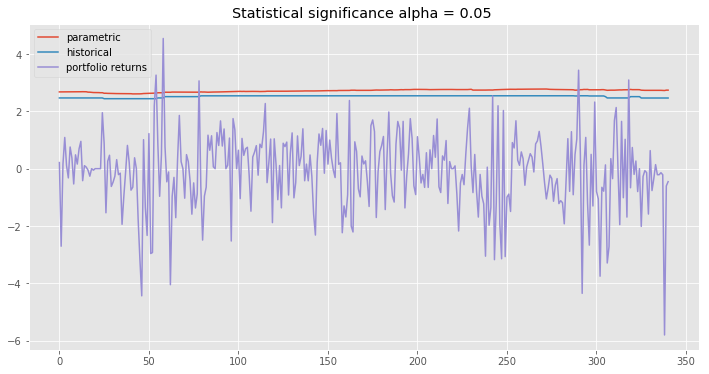

In [10]:
plt.style.use('ggplot')
plt.figure(figsize = (12,6))
plt.plot(Pvar5, label = "parametric")
plt.plot(Hvar5, label = "historical")
plt.plot(days.values, label = "portfolio returns" )
plt.legend(loc = 2)
plt.title("Statistical significance alpha = 0.05 ")
plt.show()